# Importing Libraries

In [1]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

from torch.utils.data import Dataset, DataLoader, random_split



/home/rhythm/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


# make sure the output from cnn is the number of eatures you want.

In [2]:
# directory path 
directory_path = './origen_interview_data/'

In [3]:
#feature directories 
feature_directories = ['PERMX/','PERMY/','PERMZ/','DEPTH','PORO','PORV','SATNUM','TRANX','TRANY','TRANZ']


# Loading Data

In [4]:
spatial_features = ["permx", "permy", "permz","depth", "poro", "porv", "satnum", "tranx", "trany", "tranz"] # has 3D map informations
temporal_features = ["bhps"] # changes with time
nRealisation = 500

## spatial data in a stack

In [5]:
nx, ny, nz = 15,25,24 # shape of the mesh 

In [6]:
# Loop over each feature directory
spatial_data = []

for feature_idx, feature_directory in enumerate(feature_directories):
    # Initialize an array to store the data for one feature
    feature_data = []

    # Loop over each file in the feature directory
    for file_idx in range(1, nRealisation+1):
        file_path = os.path.join(directory_path,feature_directory, f'sim{file_idx}_{spatial_features[feature_idx] }.npy')

        # Check if the file exists
        if os.path.exists(file_path):
          
            # Load the data and append it to the feature_data
            data = np.load(file_path).reshape(nx, ny, nz) #loading the spatial data 
            feature_data.append(data)
        else:
            print(f"File not found: {file_path}")

    # Convert the feature_data to a NumPy array
    feature_data = np.array(feature_data)
    
    # Append the feature_data to the list of features_data
    spatial_data.append(feature_data)

    # Display the shape of the loaded data
   # print(f"Shape of loaded data for feature {spatial_features[feature_idx]}: {feature_data.shape}")

# Convert the list of features_data to a NumPy array
spatial_data = np.array(spatial_data)
spatial_data = np.transpose(spatial_data, (1,0,2,3,4))
print(f'shape of the spatial dependent quantities : {spatial_data.shape}')


shape of the spatial dependent quantities : (500, 10, 15, 25, 24)


## temporal data - for all the wells

In [9]:
# List to store data for each feature
temporal_features_data = []

# Feature directories
temporal_directory = ['/home/rhythm/Research/ml/origen/origen_interview_data/BHP/']

# Loop over each feature directory
for feature_idx, feature_directory in enumerate(temporal_directory):
    # Initialize an array to store the data for one feature
    temporal_data = []

    # Loop over each file in the feature directory
    for file_idx in range(1, nRealisation + 1):
        file_path = os.path.join(feature_directory, f'sim{file_idx}_bhps.npy')
        # Check if the file exists
        if os.path.exists(file_path):
            # Load the data and append pressure for well #1 to the temporal_data
            data = np.load(file_path)
            temporal_data.append(data)
        else:
            print(f"File not found: {file_path}")

    # Convert the temporal_data to a NumPy array
    temporal_data = np.array(temporal_data)
    
    # Append the temporal_data to the list of temporal_features_data
    temporal_features_data.append(temporal_data)

    # Display the shape of the loaded data

# Convert the list of temporal_features_data to a NumPy array
temporal_features_data = np.array(temporal_features_data)
#temporal_data = temporal_data.flatten()
print(f"Shape of loaded data for feature {feature_idx + 1}: {temporal_data.shape}")

Shape of loaded data for feature 1: (500, 300, 7)


## storing flowrate

In [10]:
# List to store data for each feature
flowrate_features_data = []

# Feature directories
flowrate_directory = ['/home/rhythm/Research/ml/origen/origen_interview_data/WOPR/']

# Loop over each feature directory
for feature_idx, feature_directory in enumerate(flowrate_directory):
    # Initialize an array to store the data for one feature
    flowrate_data = []

    # Loop over each file in the feature directory
    for file_idx in range(1, nRealisation + 1):
        file_path = os.path.join(feature_directory, f'sim{file_idx}_wopr.npy')
        # Check if the file exists
        if os.path.exists(file_path):
            # Load the data and append pressure for well #1 to the temporal_data
            data = np.load(file_path)
            flowrate_data.append(data)
        else:
            print(f"File not found: {file_path}")

    # Convert the temporal_data to a NumPy array
    flowrate_data = np.array(flowrate_data)
    
    # Append the temporal_data to the list of temporal_features_data
    flowrate_features_data.append(flowrate_data)

    # Display the shape of the loaded data

# Convert the list of temporal_features_data to a NumPy array
flowrate_features_data = np.array(flowrate_features_data)
#temporal_data = temporal_data.flatten()
print(f"Shape of loaded data for feature {feature_idx + 1}: {flowrate_data.shape}")

Shape of loaded data for feature 1: (500, 300, 7)


## converting to tensors

In [11]:
#spatial_tensor  = torch.tensor(np.transpose(spatial_data, axes =(0, 2, 1, 3)), dtype=torch.float32)
spatial_tensor  = torch.tensor(spatial_data, dtype=torch.float32)
temporal_tensor = torch.tensor(temporal_data, dtype=torch.float32)
flowrate_tensor = torch.tensor(flowrate_data, dtype=torch.float32)
print(f'dimenstion of spatial_tensor  : {spatial_tensor.shape}')
print(f'dimenstion of temporal_tensor : {temporal_tensor.shape}')
print(f'dimenstion of flowrate_tensor : {flowrate_tensor.shape}')

dimenstion of spatial_tensor  : torch.Size([500, 10, 15, 25, 24])
dimenstion of temporal_tensor : torch.Size([500, 300, 7])
dimenstion of flowrate_tensor : torch.Size([500, 300, 7])


[nRealisations, nSpatialFeatures, nx,ny,nz]


[nRealisations, nTimeStamps, nWells]

## 

## Dataset

In [12]:

class SpatialTemporalDataset(Dataset):
    def __init__(self, spatial,temporal,flowRate, transform=None):
        self.spatial = spatial
        self.temporal = temporal
        self.flowRate = flowRate
        self.transform = transform

    def __len__(self):
        # Return the length of any of the datasets (assuming they have the same length)
        return len(self.spatial)

    def __getitem__(self, index):
        spatial = self.spatial[index]
        temporal = self.temporal[index] 
        flowRate = self.flowRate[index] 

        if self.transform:
            # Apply transformation if specified
            spatial, temporal, flowRate = self.transform(spatial, temporal, flowRate)
        return torch.Tensor(spatial), torch.Tensor(temporal), torch.Tensor(flowRate)



In [13]:


# Create a PyTorch dataset
simulated_dataset  = SpatialTemporalDataset(spatial_data,temporal_data,flowrate_data)


### Train, valid, Test

In [14]:
nTrain = 450#450
nValid = 25
nTest  = 25

In [255]:
## 
# Use random_split to create the datasets
#spatail_train_dataset, spatail_valid_dataset, spatail_test_dataset = random_split(spatial_dataset, [nTrain, nValid, nTest])

#temporal_train_dataset, temporal_valid_dataset, temporal_test_dataset = random_split(temporal_dataset, [nTrain, nValid, nTest])


In [15]:
train_dataset, valid_dataset, test_dataset = random_split(simulated_dataset, [nTrain, nValid, nTest])


### dataLoader

In [16]:

# Create DataLoader for validation
batch_size = 64
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dl   = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dl  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


# EDA

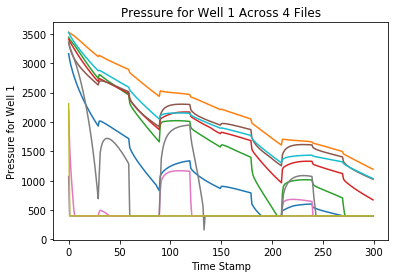

In [55]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Number of files for each feature
num_files = 10

# Feature directories
feature_directories = ['/home/rhythm/Research/ml/origen/origen_interview_data/BHP/']

# Loop over each feature directory
for feature_idx, feature_directory in enumerate(feature_directories):
    # Initialize an array to store the data for well 1
    well1_data = []

    # Loop over each file in the feature directory
    for file_idx in range(1, num_files + 1):
        file_path = os.path.join(feature_directory, f'sim{file_idx}_bhps.npy')
        # Check if the file exists
        if os.path.exists(file_path):
            # Load the data and append pressure for well #1 to the well1_data
            data = np.load(file_path)[:, 0]
            plt.plot(np.arange(0, 300), data)  # Plot each well's pressure as a separate line

# Add labels and title
plt.xlabel('Time Stamp')
plt.ylabel('Pressure for Well 1')
plt.title('Pressure for Well 1 Across 4 Files')
plt.show()


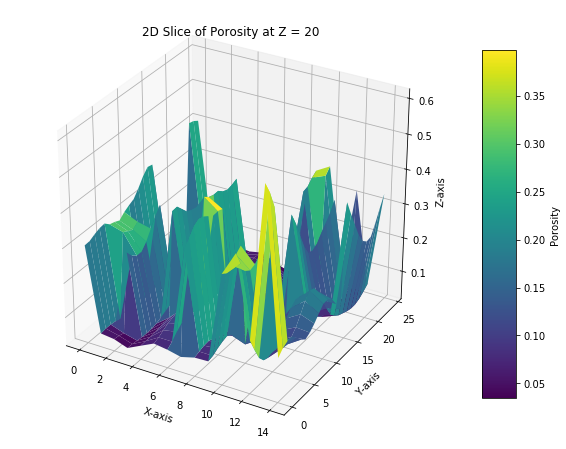

In [57]:

from mpl_toolkits.mplot3d import Axes3D

# Load the porosity data
#poro_data = np.load("simXXX_poro.npy").reshape(15, 25, 24)
sim_poro = np.load('./origen_interview_data/PORO/sim100_poro.npy').reshape(15,25,24)
# Choose a constant value along the Z-axis
z_slice = 20  # You can choose any slice you prefer
z_data = sim_poro[:, :, z_slice]

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a meshgrid for x and y coordinates
x, y = np.meshgrid(range(15), range(25), indexing='ij')

# Plot the 3D surface plot for porosity
surface = ax.plot_surface(x, y, z_data, rstride=1, cstride=1, cmap=plt.cm.viridis, shade=False)

# Add color bar
cbar = fig.colorbar(surface, ax=ax, shrink=0.8, aspect=10)
cbar.set_label('Porosity')

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('2D Slice of Porosity at Z = {}'.format(z_slice))

# Show the plot
plt.show()


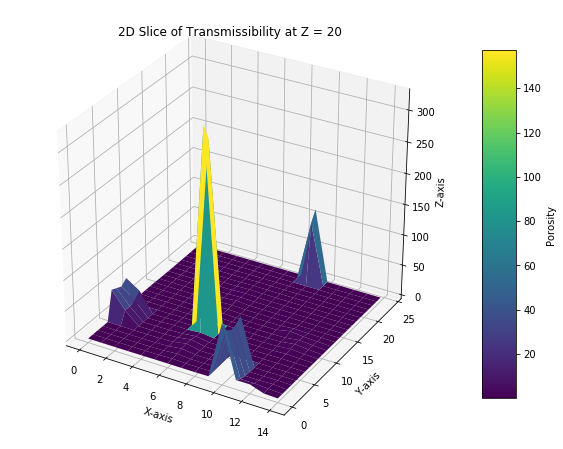

In [60]:
from mpl_toolkits.mplot3d import Axes3D

# Load the porosity data
#poro_data = np.load("simXXX_poro.npy").reshape(15, 25, 24)
sim_poro = np.load('./origen_interview_data/TRANZ/sim100_tranz.npy').reshape(15,25,24)
# Choose a constant value along the Z-axis
z_slice = 20  # You can choose any slice you prefer
z_data = sim_poro[:, :, z_slice]

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a meshgrid for x and y coordinates
x, y = np.meshgrid(range(15), range(25), indexing='ij')

# Plot the 3D surface plot for porosity
surface = ax.plot_surface(x, y, z_data, rstride=1, cstride=1, cmap=plt.cm.viridis, shade=False)

# Add color bar
cbar = fig.colorbar(surface, ax=ax, shrink=0.8, aspect=10)
cbar.set_label('Porosity')

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('2D Slice of Transmissibility at Z = {}'.format(z_slice))

# Show the plot
plt.show()

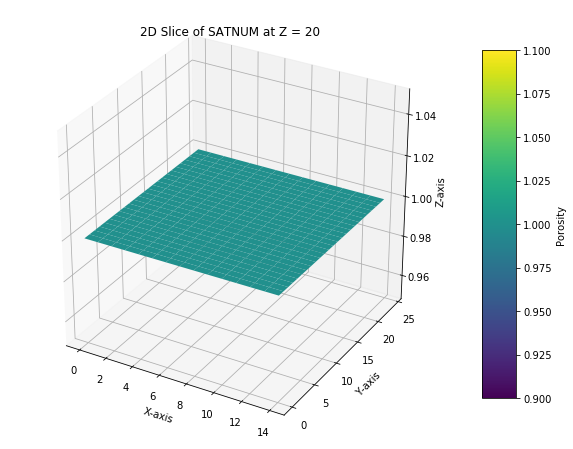

In [63]:
from mpl_toolkits.mplot3d import Axes3D

# Load the porosity data
#poro_data = np.load("simXXX_poro.npy").reshape(15, 25, 24)
sim_poro = np.load('./origen_interview_data/SATNUM/sim100_satnum.npy').reshape(15,25,24)
# Choose a constant value along the Z-axis
z_slice = 20  # You can choose any slice you prefer
z_data = sim_poro[:, :, z_slice]

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a meshgrid for x and y coordinates
x, y = np.meshgrid(range(15), range(25), indexing='ij')

# Plot the 3D surface plot for porosity
surface = ax.plot_surface(x, y, z_data, rstride=1, cstride=1, cmap=plt.cm.viridis, shade=False)

# Add color bar
cbar = fig.colorbar(surface, ax=ax, shrink=0.8, aspect=10)
cbar.set_label('Porosity')

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('2D Slice of SATNUM at Z = {}'.format(z_slice))

# Show the plot
plt.show()

# Modeling

To  learn from the petrophysical properties  I chose to build a 

1. 3D CNN (grasping the spatial properties)+ 1D CNN (grasping the time dependent properties )

2. The results of it were then fed into deep neural network to predict the flow-rate

I also think there could have been other possible ways to do it too and, i would have liked to do them as well but, given the time constraints i didn't choose to. I believe one could have also done the Recurrent Convolution Neural Network. 

### model for spatial properties 3D CNN

We see there are 10 features that have been expressed using 3d maps suthc that there values changes as we move along the gird. 
We can do the feature engineering sing 3D CNN  

In [17]:
class cnn3dspatial(nn.Module):
    def __init__(self):
        super(cnn3dspatial, self).__init__()

        #in_channel = nFeature = 10 in our case
        # 3D Convolutional layer
        self.conv3d_layer = nn.Conv3d(in_channels=10, out_channels=6, kernel_size=(3,3,3), padding=(1, 1, 1), stride = 1)
        # Batch Normalization after the 1st convolutional layer
        self.batch_norm1 = nn.BatchNorm3d(6)
      
        self.conv3d_layer2 = nn.Conv3d(in_channels=6, out_channels=2, kernel_size=(3,3,3), padding=0)
        self.batch_norm2 = nn.BatchNorm3d(2) # 
      
        # Activation function (ReLU)
        self.relu = nn.ReLU()

        # MaxPooling layer
        self.maxpool3d_layer = nn.MaxPool3d(kernel_size=(2,2,2), stride=2)    
      
    def forward(self, x):
        # Input x has shape (batch_size, in_channels, depth, height, width)
        
        # Apply 3D Convolution
        x = self.conv3d_layer(x)
      #  print(x.shape)
        x = self.batch_norm1(x)
        # Apply ReLU activation
        x = self.relu(x)
      
        # Apply 2nd 1D Convolution
        x = self.conv3d_layer2(x)
      #  print(x.shape)
        x = self.batch_norm2(x)
        # Apply ReLU activation
        x = self.relu(x)
       # print(x.shape)
      
      #  print(x.shape)
        # Apply MaxPooling
        x = self.maxpool3d_layer(x)
      #  print(x.shape)
         
        return x


### CNN for WBPH across all the wells


To learn from how pressure changes in the time span of 300 days where it is assumed that the pressure at (t+dt) across all the loction of well and assuming that the petrophysical properties don't change with time it can be treated separately. 

Building a 1D cnn model to learn the changes in time domian and extract important features out of it. 


here in_channel would be the number of wells, since we would be also interested in how individually it changes for each well. Intput x wille be (batch_size, in_feature, timeduration (length of sequence))

In [18]:

class cnn1dtemporal(nn.Module):
    def __init__(self):
        super(cnn1dtemporal, self).__init__()

        # 1D Convolutional layer
        self.conv1d_layer = nn.Conv1d(in_channels=7, out_channels=5, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm1d(5)
       # 2nd 1D Convolutional layer
        self.conv1d_layer2 = nn.Conv1d(in_channels=5, out_channels=4, kernel_size=4, padding=0)
        self.batch_norm2 = nn.BatchNorm1d(4)
        # 3 1D Convolutional layer
        self.conv1d_layer3 = nn.Conv1d(in_channels=4, out_channels=2, kernel_size=5, padding=0)
        self.batch_norm3 = nn.BatchNorm1d(2)
 
        # Activation function (ReLU)
        self.relu = nn.ReLU()
        # MaxPooling layer
        self.maxpool1d_layer = nn.MaxPool1d(kernel_size=4, stride=1)
              

    def forward(self, x):
        # Input x has shape (batch_size, 1, sequence_length)
        
        # Apply 1D Convolution
        x = self.conv1d_layer(x)  # Add channel dimension
      #  print(x.shape)
        x = self.batch_norm1(x)
        # Apply ReLU activation
        x = self.relu(x)

        x = self.conv1d_layer2(x)  # Add channel dimension
      #  print(x.shape)
        x = self.batch_norm2(x)
        # Apply ReLU activation
        x = self.relu(x)
        
        x = self.conv1d_layer3(x)  # Add channel dimension
      #  print(x.shape)
        x = self.batch_norm3(x)
        # Apply ReLU activation
        x = self.relu(x)
        
        # Apply MaxPooling
        x = self.maxpool1d_layer(x)
        #print(x.shape)
        
        
        return x


### Deep Network to learn from temporal and spatial components together 

In [19]:
class deepmodel(nn.Module):
    def __init__(self, input_size):
        super(deepmodel, self).__init__()

        # Fully connected layers
        self.fc1 = nn.Linear(input_size, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 300)

    def forward(self, x):
        # Flatten the input if needed
        x = torch.flatten(x, 1)  # Modify this based on the input shape

        # Fully connected layers with ReLU activations
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)

        return x

## model 


It combines the output from 3D CNN and 1D CNN.
The output is fed into deep model
The given model does the above mentioned things

In [20]:


class CombinedModel(nn.Module):
    def __init__(self, cnn3d_model, cnn1d_model, ann_model):#,inputSize):
        super(CombinedModel, self).__init__()

        self.cnn3d_model = cnn3d_model # Simple3DCNN
        self.cnn1d_model = cnn1d_model # Simple1DCNNAllWell
        self.ann_model = ann_model#(inputSize)

    def forward(self, x_3d, x_1d): # x_3d =  permuted_tensor,  x_1d = temporal_data_tensor
        # Forward pass through the 3D CNN model
        
        output_3d = self.cnn3d_model(x_3d)
        output_3d_forANN = output_3d.view(output_3d.size(0), -1)
      #  print(f'output_3d :{output_3d.shape}')
        # Forward pass through the 1D CNN model
        output_1d = self.cnn1d_model(x_1d)
     #   print(f'output_1d : {output_1d.shape}')
        output_1d_forANN = output_1d.view(output_1d.size(0), -1)
      
        # Concatenate the outputs from the CNN models
        combined_output = torch.cat((output_3d_forANN, output_1d_forANN), dim=1)
     #   print(f'combined_output : {combined_output.shape}')
        # Forward pass through the ANN model
        final_output = self.ann_model(combined_output)
       # print(final_output.shape)

        return final_output



# Training

### Loss Function and Optimiser

Since we have to predict the flow rate a good metric to do so would be to minimise the Mean Square Error

In [21]:
loss_fn = nn.MSELoss()

In [22]:
# instantiatnig the model
spatial = cnn3dspatial() 
temporal = cnn1dtemporal()
deep = deepmodel(input_size = 2032) # input_size = 2032 from concated line we got that
model = CombinedModel(spatial,temporal,deep )

In [23]:
optimiser = optim.Adam(model.parameters(), lr = 0.01)

In [53]:
# Training loop
num_epochs = 100
# run another loop for the well j 
wellNum = 6  # well number are changed from 0-6

# Initialize NumPy arrays to store training and testing losses
train_losses = np.zeros((num_epochs,2))
val_losses = np.zeros((num_epochs,2))
test_losses = np.zeros((num_epochs,2))
for epoch in range(num_epochs):
    for spatial_ds, temporal_ds, flowrate_ds in train_dl:
        temporal_ds = temporal_ds.permute(0,2,1)
        flowrate_ds = flowrate_ds[:,:,wellNum].flatten()
        
       # print(flowrate_ds.shape)
        # Forward pass
        output_combined = model(spatial_ds, temporal_ds)
        outputs = output_combined.flatten()
       # print(outputs.shape)
        loss = loss_fn(outputs, flowrate_ds)
       
        ## Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
#
    ##print(loss)
    ## Backward pass and optimization
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        train_losses[epoch,0] = epoch
        train_losses[epoch,1] += loss.item()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

         # Validation loop
    with torch.no_grad():
        for spatial_ds_val, temporal_ds_val, flowrate_ds_val in val_dl:
            temporal_ds_val = temporal_ds_val.permute(0, 2, 1)
            flowrate_ds_val = flowrate_ds_val[:, :, wellNum].flatten()

            # Forward pass (no optimization step during validation)
            output_combined_val = model(spatial_ds_val, temporal_ds_val)
            outputs_val = output_combined_val.flatten()
            val_loss = loss_fn(outputs_val, flowrate_ds_val)

            # Update the validation loss for the current epoch
            val_losses[epoch, 0] = epoch
            val_losses[epoch, 1] += val_loss.item()

#       
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {val_loss.item()}')

# Save the NumPy arrays to files
#np.save('loss_training0.npy', train_losses)
#np.save('loss_val0.npy', val_losses)
#
model.eval()

# Initialize a list to store predictions
test_predictions = []

# Iterate over the test dataset
with torch.no_grad():
    for spatial_ds_test, temporal_ds_test, flowrate_ds_test in test_dl:
        # Permute temporal dimensions
        temporal_ds_test = temporal_ds_test.permute(0, 2, 1)
        flowrate_ds_test = flowrate_ds_test[:, :, wellNum].flatten()

        # Forward pass
        output_combined_test = model(spatial_ds_test, temporal_ds_test)
        outputs_test = output_combined_test.flatten()
        test_loss = loss_fn(outputs_test, flowrate_ds_test)

        # Update the validation loss for the current epoch
        test_losses[epoch, 0] = epoch
        test_losses[epoch, 1] += test_loss.item()

#       
        #print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {test_losses.item()}')

        # Collect predictions
        test_predictions.append(outputs_test.cpu().numpy())

# Concatenate predictions into a single NumPy array
test_predictions = np.concatenate(test_predictions, axis=0)
np.save('loss_testing6.npy', test_losses)
#
# Optionally, post-process or convert the predictions
# For example, if your target variable is a scalar, you might want to round or clip the predictions

# Save or use the predictions as needed
np.save('test_predictions6.npy', test_predictions.reshape(25,300))
#print(test_predictions.size)

Epoch [1/100], Loss: 22513966.0
Epoch [1/100], Loss: 21790846.0
Epoch [1/100], Loss: 29679480.0
Epoch [1/100], Loss: 23768856.0
Epoch [1/100], Loss: 19437608.0
Epoch [1/100], Loss: 19799842.0
Epoch [1/100], Loss: 16587317.0
Epoch [1/100], Loss: 33125976.0
Epoch [1/100], Loss: 24659604.0
Epoch [2/100], Loss: 14724553.0
Epoch [2/100], Loss: 13610662.0
Epoch [2/100], Loss: 16073358.0
Epoch [2/100], Loss: 15285661.0
Epoch [2/100], Loss: 12264731.0
Epoch [2/100], Loss: 14099441.0
Epoch [2/100], Loss: 8956554.0
Epoch [2/100], Loss: 6659923.0
Epoch [2/100], Loss: 20420500.0
Epoch [3/100], Loss: 10843604.0
Epoch [3/100], Loss: 11312507.0
Epoch [3/100], Loss: 13040631.0
Epoch [3/100], Loss: 12130400.0
Epoch [3/100], Loss: 8769495.0
Epoch [3/100], Loss: 11434992.0
Epoch [3/100], Loss: 8472273.0
Epoch [3/100], Loss: 2524875.0
Epoch [3/100], Loss: 18485604.0
Epoch [4/100], Loss: 8762537.0
Epoch [4/100], Loss: 8156470.0
Epoch [4/100], Loss: 10677004.0
Epoch [4/100], Loss: 9773414.0
Epoch [4/100], L

In [64]:
nwell1 = np.load('./test_predictions0.npy')
nwell2 = np.load('./test_predictions1.npy')
nwell3 = np.load('./test_predictions2.npy')
nwell4 = np.load('./test_predictions3.npy')
nwell5 = np.load('./test_predictions4.npy')
nwell6 = np.load('./test_predictions5.npy')
nwell7 = np.load('./test_predictions6.npy')

In [65]:
# Stack arrays along a new axis (axis=2)
stacked_array = np.stack((nwell1, nwell2, nwell3, nwell4, nwell5, nwell6, nwell7), axis=2)


In [68]:
stacked_array_t = np.transpose(stacked_array, (0,2,1))
stacked_array_t.shape

(25, 7, 300)

In [69]:
np.save('testPredictionForAllArray.npy', stacked_array_t)


# Hyper-parameter Optimization


Learning Rate (learning_rate): The step size in updating the model weights during optimization. Optimize this to find a balance between convergence speed and stability.

Dropout Rate (dropout_rate): The probability of dropout during training. Dropout is a regularization technique that helps prevent overfitting.

Batch Size (batch_size): The number of samples used in each iteration of training. Smaller batch sizes may provide more generalization, while larger batch sizes can lead to faster training.

Number of Layers (num_layers): The depth of your neural network. This is a discrete parameter that determines the number of hidden layers in your model.

------Number of Units in Hidden Layers (hidden_units): The number of neurons or units in each hidden layer. This is a continuous parameter that influences the model's capacity.

Kernel Size (kernel_size): The size of the convolutional kernel in convolutional layers. It determines the spatial extent of the filter.

----Number of Filters (num_filters): The number of filters or output channels in convolutional layers. It controls the capacity and expressiveness of the convolutional layers.

-------Weight Decay (weight_decay): L2 regularization term added to the loss function to penalize large weights.

Optimizer Choice (optimizer): The optimization algorithm used during training, such as Adam, SGD, RMSprop, etc.

Activation Function (activation): The non-linear function applied to the output of each layer, such as ReLU, Sigmoid, Tanh, etc.